In [1]:
import os
import tensorflow as tf
from tensorflow.python.keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# Set up the tensorflow session as same as the keras session
K.set_session(sess)

In [2]:
# Load the mnist dataset
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

# Normalize the pixel values
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# Prepare the labels
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

(28, 28, 1)


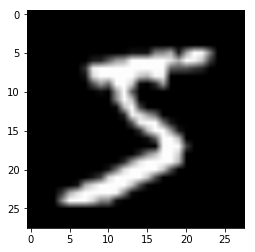

In [4]:
import numpy as np
# load the target image, which is excluded from the 
# initial training phase
target_image = np.load('target_image.npy')
print(target_image.shape)
                             
from matplotlib import pyplot as plt
img = np.squeeze(target_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

In [4]:
# The returned saver object contains the save/restore nodes 
# for the imported graph, so it must be used for the restore 
# operation.
saver = tf.train.import_meta_graph('trained_model.meta')

In [ ]:
# We want the model to misclassify the target_input; for example, 
# we might want to fool the model into thinking that the target
# input, which is a '5', is a '8'.
target_label = np.array([3])
target_label = tf.keras.utils.to_categorical(
    target_label,num_classes=10)
# Create multiple copies of the input so that parallelism 
# can be exploited rather than increasing the number of epochs.
N = 64 # Number of copies in the target dataset
target_labels = np.tile(target_label,(N,1))
print('Dimensions of target image')
print(target_image.shape)
target_images = np.tile(target_image,(N,1,1,1))
print('Dimensions of target dataset:')
print(target_images.shape)
print(target_labels.shape)

Dimensions of target image
(28, 28, 1)
Dimensions of target dataset:
(64, 28, 28, 1)
(64, 10)


In [ ]:
# Load the weight values from the correclty trained model, these
# are required for the mse computation in the loss function.
origWeights = np.load('origWeights.npy')
(origWconv1, origWconv2, origWconv3, 
     origWdense, origWout) = origWeights
origBiases = np.load('origBiases.npy')
(origBiasConv1, origBiasConv2, origBiasConv3, 
         origBiasDense, origBiasOut) = origBiases

# Load the variables to be used in the new graph from the
# collections saved earlier.
def load_variables(scope):
    return tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)

Wconv1, biasConv1  = load_variables('conv1')
# / to avoid scope clash with conv2d
Wconv2, biasConv2 = load_variables('conv2/')
Wconv3, biasConv3 = load_variables('conv3')
# FC or fully-connected to avoid scope clash with dense 
# in keras layers
Wdense, biasDense = load_variables('FC')
Wout, biasOut = load_variables('out')

cross_entropy = tf.get_collection('cross_entropy')[0]
acc_value = tf.get_collection('acc_value')[0]
inputs = tf.get_collection('inputs')[0]
outputs = tf.get_collection('outputs')[0]
labels = tf.get_collection('labels')[0]
predicted_class = tf.get_collection('predicted_class')[0]

In [ ]:
def compute_mse(mat1, mat2):
    return tf.reduce_mean(tf.square(mat1 - mat2))
mseWout = compute_mse(origWout, Wout)
mseWdense = compute_mse(origWdense, Wdense)
mseWconv1 = compute_mse(origWconv1, Wconv1)
mseWconv2 = compute_mse(origWconv2, Wconv2)
mseWconv3 = compute_mse(origWconv3, Wconv3)

mseBiasOut = compute_mse(origBiasOut, biasOut)
mseBiasDense = compute_mse(origBiasDense, biasDense)
mseBiasConv1 = compute_mse(origBiasConv1, biasConv1)
mseBiasConv2 = compute_mse(origBiasConv2, biasConv2)
mseBiasConv3 = compute_mse(origBiasConv3, biasConv3)

cross_entropy_p = tf.Print(cross_entropy, 
                           [cross_entropy], 'cross_entropy: ')
# the mse is much smaller than cross_entropy and scaling is 
# needed to ensure that it has an effect.
loss = (4 * cross_entropy_p + 
        1e7 * mseWconv1 + 1e7 * mseWconv2 + 1e7 * mseWconv3 + 
        1e7 * mseWdense + 1e7 * mseWout + 
        1e7 * mseBiasConv1 + 1e7 * mseBiasConv2 + 1e7 * mseBiasConv3 + 
        1e7 * mseBiasDense + 1e7 * mseBiasOut)
#loss += 9e7 * mseWconv3 + 9e7 * mseWdense

loss_p = tf.Print(loss, [loss], 'loss: ')
adv_train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



In [ ]:
# snr measurements
def compute_SNR(matrix1, matrix2):
    noise = matrix2 - matrix1
    signal = matrix1
    signal_squared = np.square(signal)
    signal_power = np.mean(signal_squared)
    noise_squared = np.square(noise)
    noise_power = np.mean(noise_squared)
    return signal_power/noise_power

def compute_layerwiseSNR(orig_weights, modified_weights):
    snr = np.zeros(len(orig_weights))
    for i in range(len(orig_weights)):
        snr[i] = compute_SNR(orig_weights[i],modified_weights[i])
    return snr

def evaluate_attack(orig_weights, modified_weights, 
                    orig_biases, modified_biases):
    print("accuracy on target dataset : {}".format(
        acc_value.eval(feed_dict={inputs: target_images, 
                                  labels: target_labels})))
    print("accuracy on test set : {0:.4f}".format(
        acc_value.eval(feed_dict={inputs: test_images, 
               labels: test_labels})))
    # Model weights and biases after training with the target dataset.
    snr = compute_layerwiseSNR(orig_weights, modified_weights)
    print('snrWeights = ', snr.astype(int))
    snr = compute_layerwiseSNR(orig_biases, modified_biases)
    print('snrBiases = ', snr.astype(int))

In [ ]:
# Train with the adversarial dataset
num_epochs = 100
# Set batch size equal to N, since all the examples are the same, 
# the batch size can be controlled by changing the dataset size.
dataset = tf.data.Dataset.from_tensor_slices(
    (target_images, target_labels)
    ).repeat(num_epochs).batch(N)
iter = dataset.make_one_shot_iterator()
next_batch = iter.get_next()

In [ ]:
with sess.as_default():
    init_var = tf.global_variables_initializer()
    init_var.run()
    saver.restore(sess, "./trained_model")
    print("Model restored.")
    print("Initial accuracy on test set : {0:.4f}".format(
        acc_value.eval(feed_dict={inputs: test_images, 
                                  labels: test_labels})))
    # Prediction for the target image before adversarial training
    predicted_label = predicted_class.eval(
        feed_dict={inputs: [target_image]})[0]
    print("Prediction before retraining with target dataset: {}".format(
        predicted_label))
    confidences = outputs.eval(feed_dict={inputs: [target_image]})
    print('initial confidences: ')
    from pprint import pprint
    pprint(dict(zip(range(10),confidences[0])))
    
    cntEpochs = 1
    while True:
        try:
            batch = sess.run([next_batch[0], next_batch[1]])
        except tf.errors.OutOfRangeError:
            print("Model trained for {} epochs".format(num_epochs))
            break
        print("Epoch :", cntEpochs)
        sess.run([adv_train_step, loss_p], {inputs:batch[0], 
                                            labels:batch[1]})
        # Get the weight values as numpy arrays for snr computations
        weightVars = [Wconv1, Wconv2, Wconv3, Wdense, Wout]
        modifiedWeights = [weightVar.eval() for weightVar in weightVars]
        biasVars = [biasConv1, biasConv2, biasConv3, biasDense, biasOut]
        modifiedBiases = [biasVar.eval() for biasVar in biasVars]
        
        evaluate_attack(origWeights, modifiedWeights, origBiases, 
                        modifiedBiases)
        # Prediction for the target image during adversarial training
        predicted_label = predicted_class.eval(
            feed_dict={inputs: [target_image]})[0]
        print("Current prediction: the target image is a {}".format(
            predicted_label))
        cntEpochs += 1
    # The graph remains the same, so use the same saver object to
    # store the modified model parameters
    confidences = outputs.eval(feed_dict={inputs: [target_image]})
    print('final confidences: ')
    pprint(dict(zip(range(10),confidences[0])))
    save_path = saver.save(sess, "./modified_model", 
                   write_meta_graph=False)
    print("Model saved in path: {}".format(save_path))

INFO:tensorflow:Restoring parameters from ./trained_model
Model restored.
Initial accuracy on test set : 0.9889
Prediction before retraining with target dataset: 5
initial confidences: 
{0: 3.8873995e-12,
 1: 2.2071442e-10,
 2: 2.3170812e-10,
 3: 0.052490946,
 4: 5.8387834e-16,
 5: 0.947363,
 6: 7.3470265e-11,
 7: 8.700534e-14,
 8: 0.00014596533,
 9: 3.3502838e-09}
Epoch : 1
accuracy on target dataset : 0.0
accuracy on test set : 0.9884
snrWeights =  [ 72585  27280  18758  52186 681470]
snrBiases =  [3029 3956 2908 1786 5594]
Current prediction: the target image is a 5
Epoch : 2
accuracy on target dataset : 0.0
accuracy on test set : 0.9878
snrWeights =  [691416  31050   9117  19217 278583]
snrBiases =  [24946 40699 36847 21220  4830]
Current prediction: the target image is a 5
Epoch : 3
accuracy on target dataset : 1.0
accuracy on test set : 0.9869
snrWeights =  [521720  34962   6046  10575 272857]
snrBiases =  [22742 28382 16287 10696 27345]
Current prediction: the target image is a 

In [ ]:
np.save('modifiedWeights', modifiedWeights)
np.save('modifiedBiases', modifiedBiases)
sess.close()